In [1]:
%load_ext autoreload
%autoreload 2

# Imports

Here we will analyse the latent space of the neural networks trained in different ways. To do this easily, we need to look at the TSNE or UMAP of the encoding for each sample and the resulting actual value of the objective (adaptation + sensitivity + precision). First we will create the model according to the settings for each run, load its weights, load the real data, run it through the encoder to get the *z*, and plot that with the actual functionality of the circuit.

In [2]:
from evoscaper.model.vae import sample_z
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from bioreaction.misc.misc import load_json_as_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import os

In [3]:
# fn_saves = os.path.join('data', '01_cvae', '2025_01_26__16_44_57', 'saves_2025_01_26__16_44_57_sens_kl_5e4_epochs100')  # Same as above but no categorical (onehot) and with KL weight = 5e-4 and 100 epochs
dir_src = os.path.join('data', '01_cvae', '2025_01_23__15_38_01')
fn_saves = os.path.join(dir_src, 'saves_2025_01_23__15_38_01_sens')
saves_loaded = load_json_as_dict(fn_saves)

# df_hpos = pd.DataFrame(load_json_as_dict('data/03_cvae_multi/2025_01_15__10_59_22/df_hpos_main.json'))
# hpos = df_hpos.iloc[11]
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))

top_write_dir = os.path.join('data', '04_latent', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

print(dir_src, top_write_dir)

data/01_cvae/2025_01_23__15_38_01 data/04_latent/2025_01_26__16_03_30


In [4]:
# for hpos in df_hpos.iterrows():

(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    _, 
    encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

In [5]:
h_all = encoder(params, rng, np.concatenate([x, cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=False)

cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()


In [6]:
def bin_array(data, num_bins=10):
    original_shape = data.shape
    flattened_data = data.flatten()
    bin_edges = np.linspace(flattened_data.min(), flattened_data.max(), num_bins + 1)
    bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    bin_indices = np.clip(np.digitize(flattened_data, bin_edges) - 1, 0, num_bins - 1)
    binned_data = np.array([bin_means[idx] for idx in bin_indices])
    binned_data = binned_data.reshape(original_shape)
    bin_labels = [f"Bin {i}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}), Mean: {bin_means[i]:.2f}"
                 for i in range(num_bins)]
    return binned_data, bin_edges, bin_labels

x_bin_all, edges, labels = bin_array(x_rev_all, num_bins=10)
x_bin_all = np.round(x_bin_all, 1)


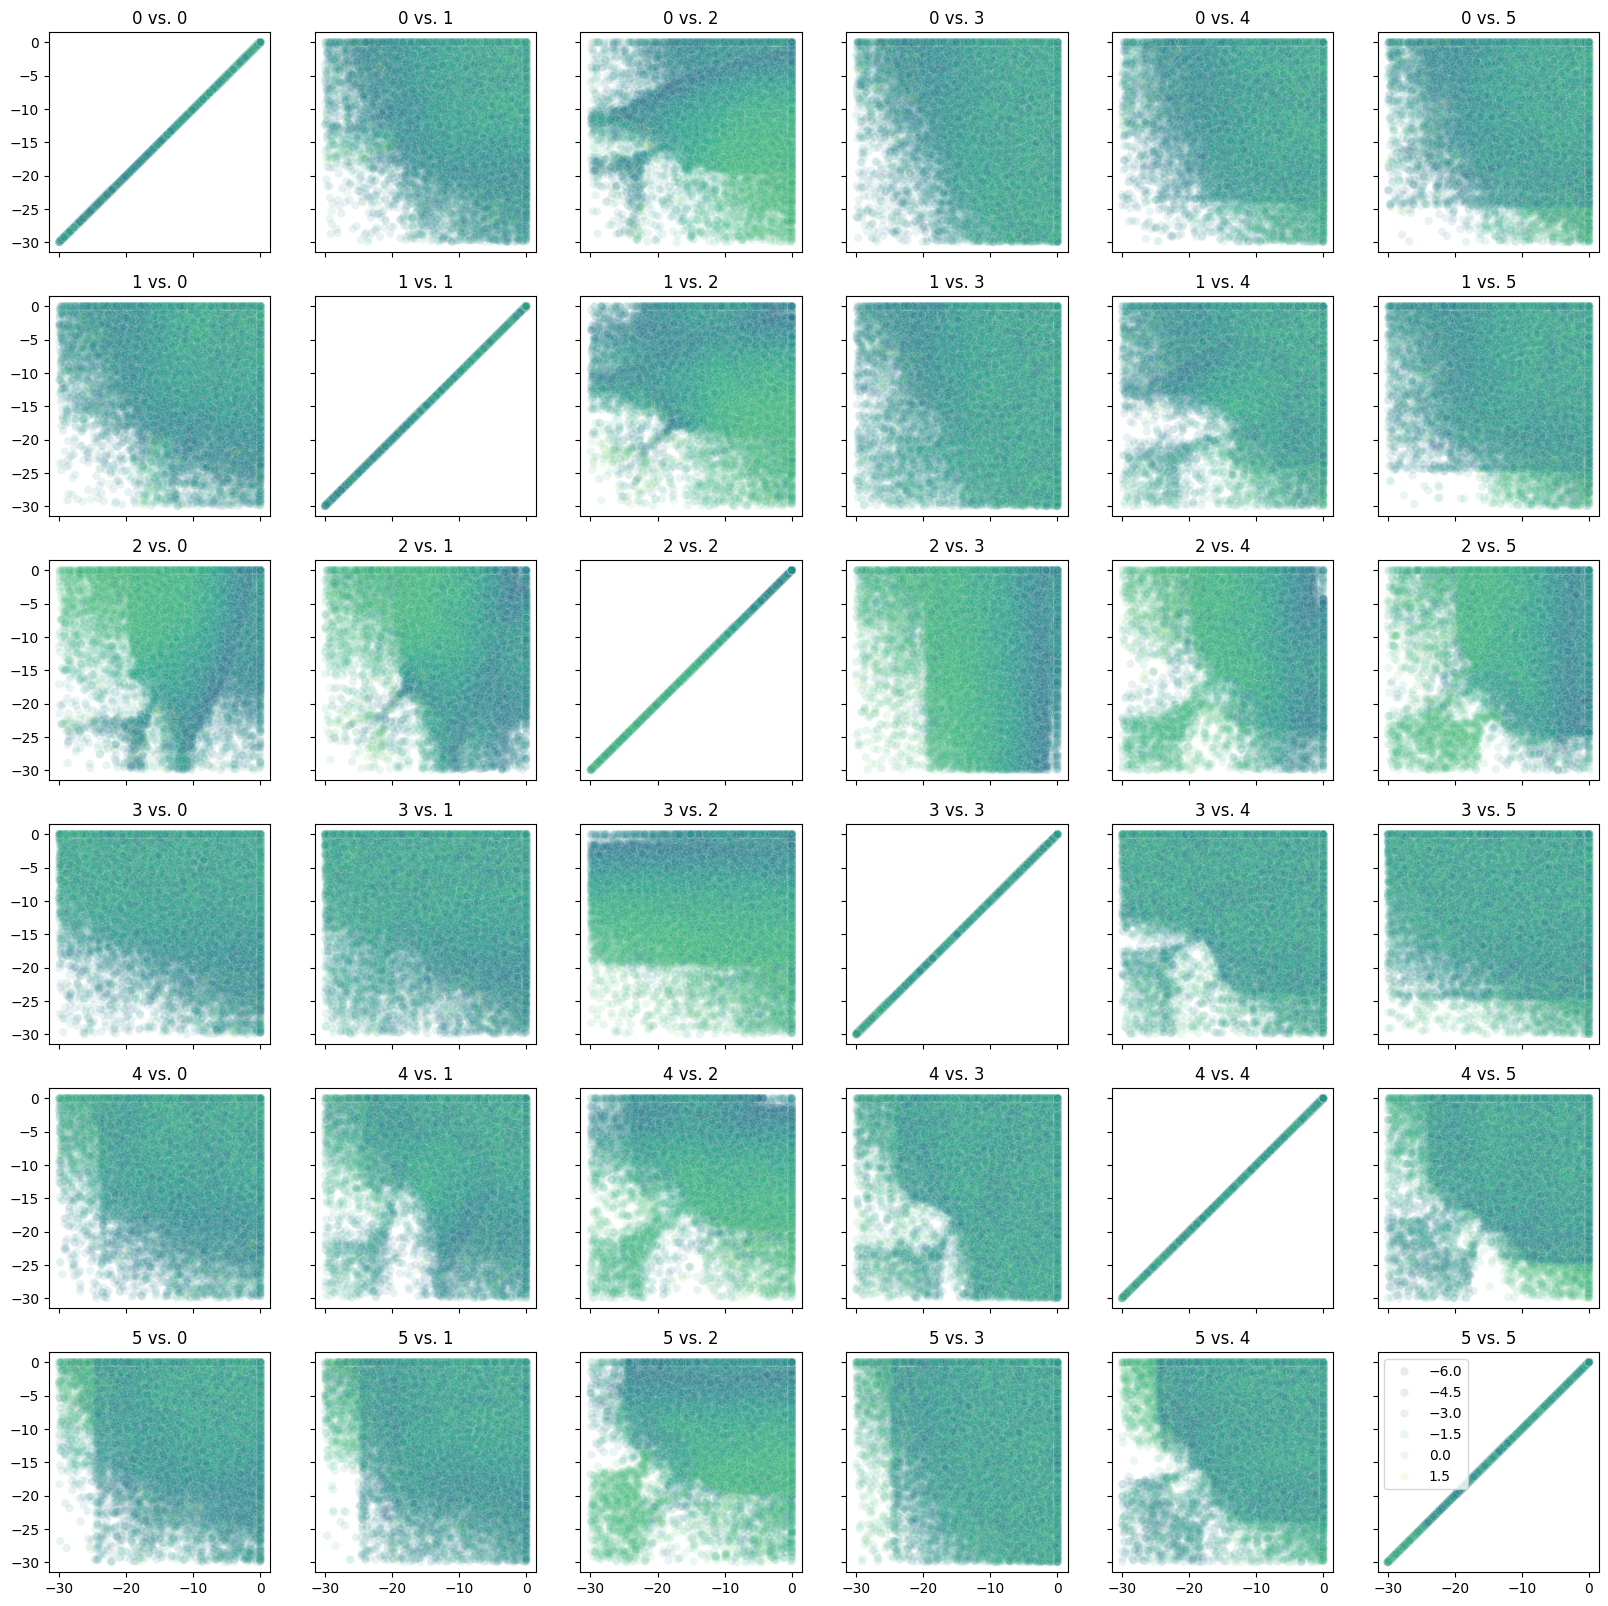

In [ ]:
plot_energy_spaces = False

if plot_energy_spaces:
    
    def plot_energy_spaces(x_rev_all, cond_rev_all):
        idxs = np.array([[(i, j) for j in range(x_rev_all.shape[-1])] for i in range(x_rev_all.shape[-1])])

        nrows = x_rev_all.shape[-1]
        ncols = x_rev_all.shape[-1]
        fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20),
                                sharex=True, sharey=True)
        for i in range(nrows):
            for j in range(ncols):
                sns.scatterplot(x=x_rev_all[..., idxs[i, j][0]], y=x_rev_all[..., idxs[i, j][1]], hue=cond_rev_all, palette='viridis', ax=axs[i, j],
                                alpha=0.1,
                                legend=True if (np.sum([i, j] != idxs[-1, -1]) == 0) else False)
                axs[i, j].set_title(f"{idxs[i, j][0]} vs. {idxs[i, j][1]}")
                # axs[i, j].set_xlabel(str(idxs[i, j][0]))
                # axs[i, j].set_ylabel(str(idxs[i, j][1]))
                
    plot_energy_spaces(x_rev_all, cond_rev_all)
    plt.savefig(os.path.join(top_write_dir, f"energy_space.png"), dpi=300)

        
    cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
    for i, c in enumerate(np.unique(cond_rev_all_binned)):
        idxs = np.where(cond_rev_all_binned == c)
        x_rev_all_c = x_rev_all[idxs]
        cond_rev_all_c = cond_rev_all_binned[idxs]
        plot_energy_spaces(x_rev_all_c, cond_rev_all_c)
        plt.savefig(os.path.join(top_write_dir, f"energy_space_{c:.2f}.png"), dpi=300)
        plt.close()

# TSNE by condition

In [8]:
perplexity = 30
tsne_results = []
random_state = 0

if not hpos.loc['prep_y_categorical']:
    cond_binned = bin_array(
        cond_rev_all, num_bins=hpos.loc['prep_y_categorical_n_bins'])[0]

for i_cond in np.arange(hpos.loc['prep_y_categorical_n_bins']):
    if hpos.loc['prep_x_categorical_onehot']:
        idxs_cond = np.where(np.argmax(cond.reshape(
            np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
        # idxs_cond = np.where(np.argmax(cond, axis=-1) == i_cond)
    else:
        idxs_cond = np.where(cond_binned.reshape(int(np.prod(
            cond_binned.shape[:-1])), -1).squeeze() == np.unique(cond_binned)[i_cond])

    h = h_all[idxs_cond]
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity if len(
        h) > perplexity else len(h) - 1, max_iter=1000)
    tsne_result = tsne.fit_transform(h)
    tsne_results.append(tsne_result)

np.save(os.path.join(top_write_dir, 'tsne_results.npy'), np.array(
    [t[:min([len(t) for t in tsne_results])] for t in tsne_results]))

In [9]:
def plot_tsne(tsne_result, hue, ax, title, palette='viridis', f=sns.scatterplot):
    f(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=hue[:len(tsne_result)], palette=palette, s=50, alpha=0.2, ax=ax)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_title(title)


obj_col = config_dataset.objective_col[0] if len(config_dataset.objective_col) == 1 else config_dataset.objective_col

# for i_cond, tsne_result in enumerate(tsne_results):
#     idxs_cond = np.where(np.argmax(cond.reshape(np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
#     x_bin = np.round(x_bin_all[idxs_cond], 1)
    
#     # plot_tsne(tsne_result, x_bin.sum(axis=-1), perplexity, ax=plt.subplot(111), palette='magma', f=sns.kdeplot)
#     plt.figure(figsize=(8*x.shape[-1] + 1, 6))
#     for i in np.arange(x.shape[-1]):
#         plot_tsne(tsne_result, x_bin[..., i], ax=plt.subplot(1, x.shape[-1] + 1, i+1), title=f"Interaction {i+1}")
#     plot_tsne(tsne_result, cond_rev_all[idxs_cond], ax=plt.subplot(1, x.shape[-1] + 1, i+2), title=obj_col)
#     plt.suptitle(f"t-SNE Visualization of Encoder Output (perplexity={perplexity}, rnd={random_state}): cond = {np.unique(cond_rev_all)[i_cond]:.2f}", fontsize=14)
#     plt.tight_layout()

#     os.makedirs(os.path.join(top_write_dir, 'cond'), exist_ok=True)
#     plt.savefig(os.path.join(top_write_dir, 'cond', f'tsne_cond_{i_cond}.png'), dpi=300)
#     plt.close()

In [10]:
ncol = x.shape[-1] + 1
fig, axes = plt.subplots(len(tsne_results), ncol, figsize=(6*ncol, 5 * len(tsne_results)), sharex=True, sharey=True)
fig.subplots_adjust(top=0.8)
for i_cond, tsne_result in enumerate(tsne_results):
    if hpos.loc['prep_x_categorical_onehot']:
        idxs_cond = np.where(np.argmax(cond.reshape(
            np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
        # idxs_cond = np.where(np.argmax(cond, axis=-1) == i_cond)
        txt_cond = f'cond = {np.unique(cond_rev_all)[i_cond]:.2f}'
    else:
        idxs_cond = np.where(cond_binned.reshape(int(np.prod(
            cond_binned.shape[:-1])), -1).squeeze() == np.unique(cond_binned)[i_cond])
        txt_cond = f'cond = {np.unique(cond_binned)[i_cond]:.2f}'

    x_bin = np.round(x_bin_all[idxs_cond], 1)
    
    p_i = ncol * i_cond
    for i in np.arange(x.shape[-1]):
        plot_tsne(tsne_result, x_bin[..., i], ax=axes[i_cond, i], title=f"Interaction {i+1}, {txt_cond}")
    plot_tsne(tsne_result, cond_rev_all[idxs_cond], ax=axes[i_cond, i + 1], title=obj_col + f', {txt_cond}')

plt.suptitle(f"t-SNE Visualization of Encoder Output (perplexity={perplexity}, rnd={random_state}): {txt_cond}", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, f'tsne_cond_all.png'))
plt.close()

Text(0.5, 1.0, 'Embedding of model')

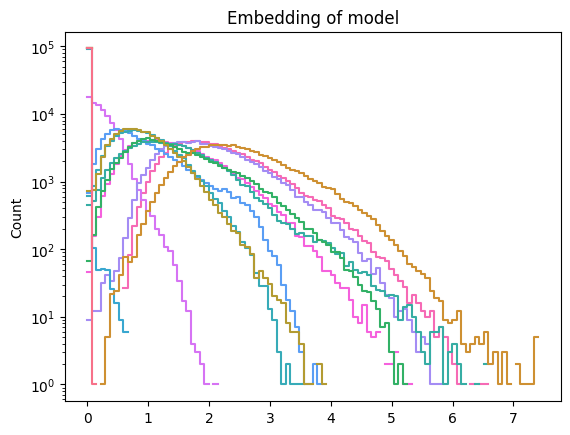

In [11]:
i_enc = encoder(params, rng, np.concatenate([x, cond], axis=-1))
sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Embedding of model')

# TSNE 2 components

In [12]:
perplexity = 30
tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, max_iter=1000)
tsne_result_2 = tsne.fit_transform(h_all)

np.save(os.path.join(top_write_dir, 'tsne_result_2.npy'), tsne_result_2)


In [13]:
def plot2(tsne_result, hue, ax, i_d1, i_d2, hue_label, n_comps, palette='viridis', f=sns.scatterplot):
    d = pd.DataFrame(data=np.array([tsne_result[:, i_d1], tsne_result[:, i_d2], hue[:len(tsne_result)]]).T, columns=[f't-SNE Dimension {i_d1+1}', f't-SNE Dimension {i_d2+1}', hue_label])
    f(d, x=f't-SNE Dimension {i_d1+1}', y=f't-SNE Dimension {i_d2+1}', hue=hue_label, palette=palette, s=50, alpha=0.2, ax=ax)
    plt.suptitle(f"t-SNE of Encoder Output (perplexity={perplexity}, n={n_comps}, rnd={random_state}, dimensions {i_d1, i_d2})", fontsize=14)

obj_col = config_dataset.objective_col[0] if len(config_dataset.objective_col) == 1 else config_dataset.objective_col
x_bin = np.round(x_bin_all, 1)
plt.figure(figsize=(7*x.shape[-1], 6))
for i in np.arange(x.shape[-1]):
    ax=plt.subplot(1, x.shape[-1], i+1)
    plot2(tsne_result_2, x_bin[..., i], ax, 0, 1, f'Energy (kcal)', n_comps=2)
    plt.title(f"Energy {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'tsne2.png'))
plt.close()


cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
plot2(tsne_result_2, cond_rev_all_binned, None, 0, 1, obj_col, n_comps=2, palette='magma', f=sns.jointplot)
plt.savefig(os.path.join(top_write_dir, f'tsne2_j.png'))
plt.close()

# TSNE 3 components

In [14]:
perplexity = 30

tsne = TSNE(n_components=3, random_state=random_state, perplexity=perplexity, max_iter=1000)
tsne_result_3 = tsne.fit_transform(h_all)

np.save(os.path.join(top_write_dir, 'tsne_result_3.npy'), tsne_result_3)


In [15]:
dims = [(0, 1), (0, 2), (1, 2)]
plt.figure(figsize=(8*(x.shape[-1]), 6 * len(dims)))
for ii, (i_d1, i_d2) in enumerate(dims):
    for i in np.arange(x.shape[-1]):
        ax=plt.subplot(len(dims), x.shape[-1], x.shape[-1] * ii + i+1)
        plot2(tsne_result_3, x_bin[..., i], ax, i_d1, i_d2, f'Energy (kcal)', n_comps=3)
        plt.title(f"Energy {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'tsne3.png'), dpi=300)
plt.close()

os.makedirs(os.path.join(top_write_dir, 'tsne3_joint'), exist_ok=True)
for i, (i_d1, i_d2) in enumerate(dims):
    ax=None
    cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
    plot2(tsne_result_3, cond_rev_all_binned, ax, i_d1, i_d2, obj_col, n_comps=3, palette='magma', f=sns.jointplot)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'tsne3_joint', f'tsne3_j{i}.png'), dpi=300)
    plt.close()
    


In [16]:
print(top_write_dir, fn_saves)

data/04_latent/2025_01_26__16_03_30 data/01_cvae/2025_01_23__15_38_01/saves_2025_01_23__15_38_01_sens
